In [2]:
import pandas as pd
from scipy.spatial.distance import jaccard

import query
import folium
from folium.plugins import MarkerCluster

For all attacks, we assume an adversary that is honest but curious. They have access to query metadata (as in queries.csv), namely IP address, location, timestamp and POI type as well as the locations that are returned by the service for each POI type (as in pois.csv). We maintain the handout's assumption that each IP address corresponds to a unique user. The common goal of these attacks is to use this data to undermine a user's privacy and find out sensitive locations (home/work) and interests.

We propose the following attacks:
1) We first show how this data allows us to map a user's movement over a certain period of time (in this case twenty days). In this attack, the adversary knows the IP address of a user and is trying to discover their sensitive locations and interests.
2) Then, we assume the adversary knows a person's sensitive locations (home / work) in real life and is trying to link that to an IP.
3) Finally, we use query.py to learn more about the user's interests and places they might frequent.

# Mapping User Movement
This attack relies on the query metadata. We use the ip_address field to isolate a user's data. We then place each query's location on a map along with the processed timestamp which, considering 05/05/2025 at 00:00 as the simulation start time, shows the date and time of day.
To make the map more readable, we include a start and end parameters to only visualize a subset of data. In this case, we might only want to see what a week looks like for this user as it typically is a cycle that repeats for most people.

In [3]:
def make_map(file, start, end, ip):
    df = pd.read_csv(
        file,
        sep='\s+',
        header=0,
        names=["ip_address", "lat", "lon", "timestamp", "poi_type_query"]
    )
    df = df[df["ip_address"] == ip]
    sim_start = pd.to_datetime("2025-05-05 00:00")
    df["datetime"] = sim_start + pd.to_timedelta(df["timestamp"], unit="h")

    start_time = sim_start + pd.Timedelta(days=start - 1)
    end_time = sim_start + pd.Timedelta(days=end)
    df = df[(df["datetime"] >= start_time) & (df["datetime"] < end_time)]

    def ordinal(n):
        if 10 <= n % 100 <= 20:
            suffix = "th"
        else:
            suffix = {1: "st", 2: "nd", 3: "rd"}.get(n % 10, "th")
        return f"{n}{suffix}"

    df["day_ordinal"] = df["datetime"].dt.day.apply(ordinal)
    df["label"] = (
        df["datetime"].dt.strftime("%A ") +
        df["day_ordinal"] +
        df["datetime"].dt.strftime(" %H:%M")
    )

    df.head()
    center = [df['lat'].mean(), df['lon'].mean()]
    m = folium.Map(location=center, zoom_start=13)
    cluster = MarkerCluster().add_to(m)

    for _, row in df.sort_values("datetime").iterrows():
        popup = folium.Popup(
            html=(
                f"<b>Time:</b> {row['label']}<br>"
                f"<b>Query:</b> {row['poi_type_query']}"
            ),
            max_width=200
        )
        folium.Marker(
            location=[row["lat"], row["lon"]],
            popup=popup,
            icon=folium.Icon(icon="info-sign")
        ).add_to(cluster)

        coords = df.sort_values("datetime")[["lat","lon"]].values.tolist()
    folium.PolyLine(
        locations=coords,
        weight=3,
        opacity=0.7
    ).add_to(m)
    return m
make_map("queries.csv", 1, 1, "146.71.112.211")

It is possible to extract different types of information depending on the selected dates. Let's assume we are following the user with IP address 146.71.112.211. We can change the start and end parameters of the python script in order to map the user's movement over a day or multiple days and know where they were at very specific times and dates. For example, here we selected day 1 which is a monday and we can see that the user was in the Renens Gare area around midday and in Prilly around the night.

This same mapping script allows us to guess users' sensitive locations. Let's view the user's locations over a week:

In [4]:
make_map("queries.csv", 1, 7, "146.71.112.211")

lWe can see that a lot of their requests still emerge from around the same two locations around Renens Gare and Prilly. We know that the two places where a person spends most of their time during a week are home and work, typically work during the day and home at night. We also usually research for places to eat for lunch while we are at work while we are usually at home during the evenings, perhaps researching places to unwind such as bars, and in the mornings on the weekend. This matches perfectly with our user's data as they often send queries for "restaurant" and "cafeteria" from 11 am to 1 pm from the location near Renens Gare, specifically at Av. du Tir-Fédéral 15, 1024 Ecublens or perhaps another building nearby. We can thus safely assume that this would be the location where they work. A quick look on Google Maps shows us that a couple of companies where this person could be working such as Holinger SA, Unimed SA or a kindergarten. We also notice that the user sends a lot of queries from the Prilly area during the week evenings or early mornings on the weekends more specifically from Chem. des Charmilles 10, 1004 Lausanne which, just from looking at the map followed by a quick sanity check on Google Map, looks like a residential area which is most likely where the user lives.

# Linking real-life identities to IP addresses
In this attack, we know some of the user's sensitive locations (home/work) and we also know that they use this application. We want to identify them in the dataset. We can do this using queries.csv and match the locations of the queries to the sensitive locations. We can then use the IP address of the user to find out more about them, such as their interests and preferences in the next attack.
This attack is essentially reversing the previous one. Let's focus on the same user as before (IP = 146.71.112.211) and assume we know that they work on the Av. du Tir-Fédéral 15, 1024 Ecublens, which corresponds to (lat: 46.53591906517015, lon: 6.575487739371415) and live on Chem. des Charmilles 10, 1004 Lausanne which corresponds to (lat: 46.53086483286677, lon: 6.623208941351423). Let's see how we can use the queries.csv file to find out how to identify the user on the dataset:
In the following script, we provide the function find_ip_by_location which takes in the user's home and work locations and a radius (in degrees) around these locations. The function will then filter the queries.csv file for queries that are sent from these locations and return the IP addresses of the users who have sent a lot of queries from there according to a couple of rules: we filter for queries around the home location on the weekend mornings or weekday evenings and for queries around the work location during the week days around lunch time.
We can then use this information to identify the user in the dataset.


In [5]:
def find_ip_by_location(file, home_lat, home_lon, work_lat, work_lon, radius=0.001):
    df = pd.read_csv(
        file,
        sep='\s+',
        header=0,
        names=["ip_address", "lat", "lon", "timestamp", "poi_type_query"]
    )
    sim_start = pd.to_datetime("2025-05-05 00:00")
    df["datetime"] = sim_start + pd.to_timedelta(df["timestamp"], unit="h")
    df["weekday"] = df["datetime"].dt.weekday
    df["hour"] = df["datetime"].dt.hour

    # filter for queries around home and work locations
    home_queries = df[
        (df["lat"].between(home_lat - radius, home_lat + radius)) &
        (df["lon"].between(home_lon - radius, home_lon + radius)) & (
            # weekend mornings
            ((df["weekday"].isin([5, 6])) & (df["hour"].between(6, 11))) |
            # weekday evenings
            ((df["weekday"].isin([0, 1, 2, 3, 4])) & (df["hour"].between(18, 23)))
        )
    ]
    work_queries = df[
        (df["lat"].between(work_lat - radius, work_lat + radius)) &
        (df["lon"].between(work_lon - radius, work_lon + radius)) & (
            # weekdays around lunchtime
            (df["weekday"].isin([0, 1, 2, 3, 4])) & (df["hour"].between(11, 14))
        )
    ]

    home_counts = home_queries.groupby("ip_address").size().reset_index(name='home_query_count')
    work_counts = work_queries.groupby("ip_address").size().reset_index(name='work_query_count')
    merged_counts = pd.merge(home_counts, work_counts, on="ip_address", how="outer").fillna(0)
    sig = merged_counts[
        (merged_counts['home_query_count'] > 0) & (merged_counts['work_query_count'] > 0)
    ]

    return sig

In [31]:
work_lat = 46.53591906517015
work_lon = 6.575487739371415

home_lat = 46.53086483286677
home_lon = 6.623208941351423

s = find_ip_by_location("queries.csv", home_lat, home_lon, work_lat, work_lon, 0.001)
print("Significant Users:\n", s)

Significant Users:
        ip_address  home_query_count  work_query_count
2  146.71.112.211              35.0              22.0


We have managed to find back the user with IP address 146.71.112.211. We can adjust the radius parameter depending on how precise our background knowledge of the user is. Here, we set it to 0.001 degrees which is around 100 meters.

# Revealing User Interests

Now that we know the IP address of the user (whether it is part of the background knowledge or a result of the previous attack), we can find out about the user's interest depending on how often they query for a specific POI type. We can also use the queries.csv file to see how often the user queries for a specific POI type and when they do so. For example, if they query for "restaurant" a lot week, we can assume that they are a foodie. If they query for "bar" or "club" a lot, we can assume that they are interested in nightlife. We can also use the POIs file to see which specific POIs are returned.

POI Types and Percentage of Queries:
supermarket: 19.42%
club: 18.45%
gym: 18.45%
cafeteria: 14.56%
restaurant: 14.56%
dojo: 14.56%


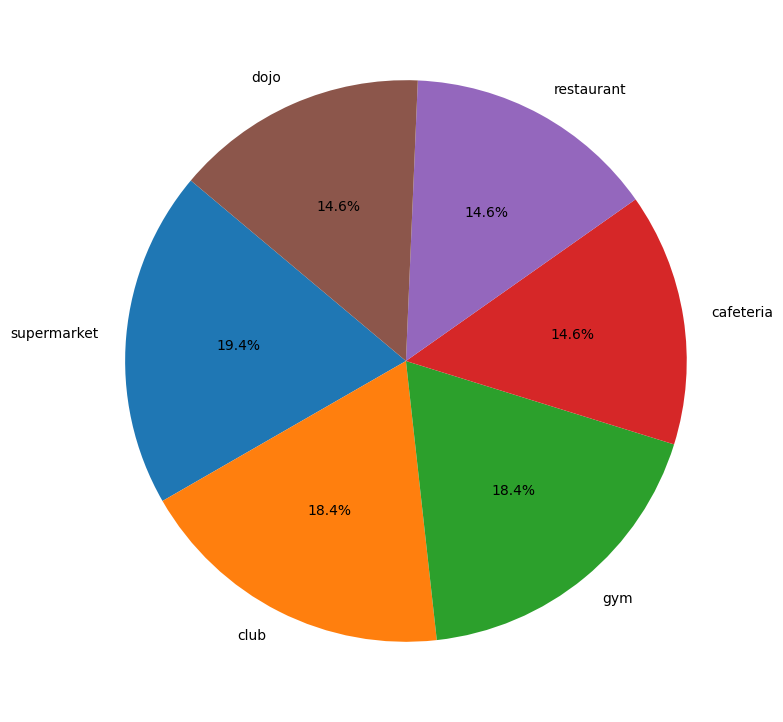

In [40]:
def get_poi_types(file, ip_address):
    df = pd.read_csv(
        file,
        sep='\s+',
        header=0,
        names=["ip_address", "lat", "lon", "timestamp", "poi_type_query"]
    )
    df = df[df["ip_address"] == ip_address]
    poi_counts = df["poi_type_query"].value_counts(normalize=True) * 100
    return poi_counts

def plot_poi_pie(poi_counts, ip_address):
    plt.figure(figsize=(8, 8))
    plt.pie(poi_counts, labels=poi_counts.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
    plt.tight_layout()
    plt.savefig(f"poi_pie_{ip_address.replace('.', '_')}.png", dpi=300)
    plt.show()

poi_types = get_poi_types("queries.csv", "146.71.112.211")
print("POI Types and Percentage of Queries:")
for poi_type, percentage in poi_types.items():
    print(f"{poi_type}: {percentage:.2f}%")
plot_poi_pie(poi_types, "146.71.112.211")

We can see that this user is interested in nightlife activities (clubbing), practice some martial arts (as the query for dojos) and goes to the gym.
We can go one step further and use the servers' responses to find out which exact clubs, dojos or gyms the user is most likely to frequent, assuming that they end up going to the places that are returned by the server. We can do this by checking the pois.csv file and seeing which POIs are returned for each POI type.

In [8]:
import numpy as np
from privacy_evaluation.query import get_nearby_pois


def load_queries(file, ip_address):
    try:
        df = pd.read_csv(
            file,
            sep='\s+',
            header=0,
            names=["ip_address", "lat", "lon", "timestamp", "poi_type_query"]
        )
    except FileNotFoundError:
        print(f"File not found")
        return pd.DataFrame()

    user_df = df[df["ip_address"] == ip_address]
    return user_df

def map_pois(file, ip_address, type="all"):
    df = load_queries(file, ip_address)
    if df.empty:
        print(f"No data found for IP address: {ip_address}")
        return None

    center = [df['lat'].mean(), df['lon'].mean()]
    m = folium.Map(location=center, zoom_start=13)
    cluster = MarkerCluster().add_to(m)

    plotted_pois = set()

    for _, row in df.iterrows():
        loc = np.array([row["lat"], row["lon"]])
        poi_type = row["poi_type_query"]

        nearby_pois = get_nearby_pois(loc, poi_type)

        for poi_id in nearby_pois:
            if poi_id not in plotted_pois and (type == "all" or poi_type == type):
                plotted_pois.add(poi_id)

                popup = folium.Popup(f"POI ID: {poi_id} - Type: {poi_type}", max_width=200)
                folium.Marker(
                    location=loc.tolist(),
                    popup=popup,
                    icon=folium.Icon(icon="info-sign")
                ).add_to(cluster)

    return m

map_pois("queries.csv", "146.71.112.211", "club")


Once we get all the POIs that are returned by the server for this user, we can guess that the user is most likely to frequent the places that are closer to their home or work, namely some gyms and dojos in Ecublens and near EPFL and some others near Prilly, where they live. In that area, multiple clubs were also returned. We can use the function map_pois to visualize where the POIs are located exactly and filter them by type.


# Defence using spatial obfuscation


The attacks above are possible because the adversary has very precise location data for the user. We choose to use spatial obfuscation as a defense. On the client side, this consists in adding noise to the location data before sending it to the server. The server will then receive a noisy location and return POIs based on it. We base our strategy on the geo-indistinguishability paper.
The obfuscate function applies Laplace noise to a location based on the latitude, longitude and the privacy parameter epsilon. The noise is drawn according to the original paper the converted to degrees since we are working with geographic coordinates. The obfuscate_queries function applies this noise to all the locations in queries.csv and saves the noisy locations to a new file noisy.csv.

In [9]:
import numpy as np
import pandas as pd

## Applies laplace noise to a location, based on Geo-Indistinguishability paper (Andres et al.)
def obfuscate(lat, lon, epsilon):
    #draw angle theta randomly from [0, 2pi)
    theta = np.random.uniform(0, 2*np.pi)

    #draw radius r from Gamma with shape=2, scale=1/epsilon
    r = np.random.gamma(shape=2, scale=1/epsilon)

    #convert r from meters to degrees (Andres et al. paper assumed metric spaces while we are in degrees)
    #conversion algorithm inspired by this answer: https://gis.stackexchange.com/a/385618
    delta_lat = (r * np.sin(theta)) / 111111
    delta_lon = (r * np.cos(theta)) / (111111 * np.cos(np.radians(lat)))

    return lat + delta_lat, lon + delta_lon

In [10]:
##apply obfuscation to all the locations in queries.csv
def obfuscate_queries(input_file, output_file, epsilon):
    df = pd.read_csv(
        input_file,
        sep='\s+',
        header=0,
        names=["ip_address", "lat", "lon", "timestamp", "poi_type_query"]
    )

    df["noisy_lat"], df["noisy_lon"] = zip(*df.apply(
        lambda row: obfuscate(row["lat"], row["lon"], epsilon), axis=1
    ))

    df[["ip_address", "noisy_lat", "noisy_lon", "timestamp", "poi_type_query"]].to_csv(
        output_file, sep=' ', index=False, header=False
    )

Let's use this to try again the previously described attacks. We will start by obfuscating the queries.csv file with an epsilon of 0.01 and map it to try to determine the user's sensitive locations.

In [11]:
obfuscate_queries("queries.csv", "noisy_0.01.csv", 0.01)
make_map("noisy_0.01.csv", 1, 7, "146.71.112.211")

We can see that the obfuscated locations are not as precise as the original ones. The user is still able to query for POIs and get results, but the adversary will not be able to pinpoint their exact location. The noise added to the locations makes it harder for the adversary to track the user's movement and identify their sensitive locations. For an epsilon of 0.01, the noise makes it difficult to determine the user's exact location, but it is still possible to see the general area where the user is located. For example, here we can still tell that the user works in the Renens Gare area. The smaller the epsilon, the more noise is added to the locations and the harder it is for the adversary to track the user's movement. However, this also means that the user will receive less accurate results when querying for POIs. The choice of epsilon is thus a trade-off between privacy and utility. We can try to decrease the epsilon to see how it affects the results. Let's try with an epsilon of 0.001:

In [12]:
obfuscate_queries("queries.csv", "noisy_0.001.csv", 0.001)
make_map("noisy_0.001.csv", 1, 7, "146.71.112.211")


We see that with a smaller epsilon, the noise is larger and the locations are more spread out. It is now harder to even point out specific areas for the sensitive locations . However, the user will also receive less accurate results when querying for POIs. Even worse, the user will not receive the same results every time they query, showcasing that the choice of epsilon is indeed a trade-off between privacy and utility.

Now, let's try to address the second attack where we try to link a real-life identity to an IP address. We will use the obfuscated queries csv files for epsilon = 0.01 and 0.001 and the find_ip_by_location function to see if we can still identify the user with IP address.


In [13]:
work_lat = 46.53591906517015
work_lon = 6.575487739371415

home_lat = 46.53086483286677
home_lon = 6.623208941351423

s = find_ip_by_location("noisy_0.01.csv", home_lat, home_lon, work_lat, work_lon, 0.001)
print("Significant Users:\n", s)

Significant Users:
        ip_address  home_query_count  work_query_count
4  146.71.112.211               8.0               7.0


In [14]:
s = find_ip_by_location("noisy_0.001.csv", home_lat, home_lon, work_lat, work_lon, 0.001)
print("Significant Users:\n", s)

Significant Users:
 Empty DataFrame
Columns: [ip_address, home_query_count, work_query_count]
Index: []


With an epsilon of 0.01, we can still identify the user with IP address. However, with an epsilon of 0.001, it is not possible anymore. Let's try with an intermediate value of epsilon = 0.007.

In [43]:
obfuscate_queries("queries.csv", "noisy_0.007.csv", 0.007)

In [44]:
s = find_ip_by_location("noisy_0.007.csv", home_lat, home_lon, work_lat, work_lon, 0.001)
print("Significant Users:\n", s)

Significant Users:
        ip_address  home_query_count  work_query_count
1     11.173.13.2               1.0               3.0
7  146.71.112.211               9.0               1.0


Now, we can identify a couple of users who correspond to our criteria. The adversary can use the number of queries from each location to determine which user is the most likely to be the one they are looking for but we can see how the noise makes it harder to pinpoint the exact user. In a more realistic case, the adversary will have to go through a lot of users and will not be able to identify the user with certainty.

Finally, let's investigate the third described attack where we try to find out the user's interests and frequented places. We can easily see that this obfuscation strategy does not directly address the attack as the adversary will still see the same results as the user. We can propose different strategies such as adding dummy queries on the client side (e.g. querying for random POI types at random times or even a more specific strategy that will mimic a normal user's behavior) or even by generalizing the POI types on both client and server sides. However, this is outside the scope of our report as we only focus on one defence implementation.

# Defence evaluation
The previous scripts were used to showcase how our defence can affect the attacks while focusing on one specific user. In this section, we will evaluate it quantitatively and rigorously.
We define the following metrics for measuring privacy:
- Precision: TP / (TP + FP) where TP is the number of true positives (obfuscated location correctly identified) and FP is the number of false positives (location incorrectly identified).
- Average distance error: Average distance between the real location and the inferred location by the adversary. This is a measure of how far off the adversary is from the real location and it should increase as our defence is improved.
- Jaccard Index: Used to measure similarity between two sets (POIs before vs after obfuscation).
- We will use these metrics to evaluate the defence while varying the epsilon parameter.

We start by preparing our data by defining the home and work locations of the users. In the following script, we go over the queries.csv file and extract the home and work locations of the users based on the queries they send according to the criteria defined in the previous analysis sections. We then save these locations to a new file called locations.csv.

In [17]:
def home_work_locations(input, output, radius=0.001):
    df = pd.read_csv(
        input,
        sep='\s+',
        header=0,
        names=["ip_address", "lat", "lon", "timestamp", "poi_type_query"]
    )
    sim_start = pd.to_datetime("2025-05-05 00:00")
    df["datetime"] = sim_start + pd.to_timedelta(df["timestamp"], unit="h")
    df["weekday"] = df["datetime"].dt.weekday
    df["hour"] = df["datetime"].dt.hour

    # filter for queries around home and work locations
    home_df = df[
        ((df["weekday"].isin([5, 6])) & (df["hour"].between(6, 8))) #|
        #((df["weekday"].isin([0, 1, 2, 3, 4])) & (df["hour"].between(20, 23)))
    ]

    # filter for work location queries:
    work_df = df[
        ((df["weekday"].isin([0, 1, 2, 3, 4])) & (df["hour"].between(11, 13)))
    ]

    home_locs = home_df.groupby("ip_address")[["lat", "lon"]].mean().reset_index()
    home_locs = home_locs.rename(columns={"lat": "home_lat", "lon": "home_lon"})

    work_locs = work_df.groupby("ip_address")[["lat", "lon"]].mean().reset_index()
    work_locs = work_locs.rename(columns={"lat": "work_lat", "lon": "work_lon"})

    # Merge home and work locations
    locations = pd.merge(home_locs, work_locs, on="ip_address", how="outer")

    # Save to CSV
    locations.to_csv(output, index=False)

home_work_locations("queries.csv", "locations.csv")

Now, we run the obfuscation algorithm for a high number of times and for different values of epsilon. We then use the previously defined function to identify the locations. We then compute the precision and privacy error for each epsilon and plot.

In [22]:
from math import radians, cos, sin

# calculate distance in meters between two lat/lon pairs
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # radius of earth
    phi1, phi2 = radians(lat1), radians(lat2)
    d_phi = radians(lat2 - lat1)
    d_delta = radians(lon2 - lon1)

    a = np.sin(d_phi/2)**2 + cos(phi1) * cos(phi2) * np.sin(d_delta/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# match predictions with ground truth
def evaluate(ground_truth, predictions, radius=250):  # radius in meters
    merged = pd.merge(ground_truth, predictions, on="ip_address", how="outer", suffixes=('_gt', '_pred'))

    tp, fp = 0, 0
    errors = []

    for _, row in merged.iterrows():
        # home locations
        gt_home_exists = not (pd.isna(row["home_lat_gt"]) or pd.isna(row["home_lon_gt"]))
        pred_home_exists = not (pd.isna(row["home_lat_pred"]) or pd.isna(row["home_lon_pred"]))

        if gt_home_exists and pred_home_exists:
            dist_home = haversine(row["home_lat_gt"], row["home_lon_gt"],
                                  row["home_lat_pred"], row["home_lon_pred"])
            errors.append(dist_home)
            if dist_home <= radius:
                tp += 1
            else:
                fp += 1
        elif pred_home_exists and not gt_home_exists:
            fp += 1

        # work locations
        gt_work_exists = not (pd.isna(row["work_lat_gt"]) or pd.isna(row["work_lon_gt"]))
        pred_work_exists = not (pd.isna(row["work_lat_pred"]) or pd.isna(row["work_lon_pred"]))

        if gt_work_exists and pred_work_exists:
            dist_work = haversine(row["work_lat_gt"], row["work_lon_gt"],
                                  row["work_lat_pred"], row["work_lon_pred"])
            errors.append(dist_work)
            if dist_work <= radius:
                tp += 1
            else:
                fp += 1
        elif pred_work_exists and not gt_work_exists:
            fp += 1

    precision = tp / (tp + fp) if (tp + fp) else 0
    avg_error = np.mean(errors) if errors else 0

    return precision, avg_error

def jaccard_index(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

In [24]:
import os

control = pd.read_csv("locations.csv")
epsilon_min = 0.001
epsilon_max = 0.05
epsilon_step = 0.001
runs_per_epsilon = 5

precision_avg = []
error_avg = []
jaccard_avg = []

precision_std = []
error_std = []
jaccard_std = []

eps = epsilon_min
epsilons = []

## get POIs for queries.csv
df = pd.read_csv(
         "queries.csv",
         sep='\s+',
         header=0,
         names=["ip_address", "lat", "lon", "timestamp", "poi_type_query"]
    )

pois = []
for _, row in df.iterrows():
    loc = np.array([row["lat"], row["lon"]])
    poi_type = row["poi_type_query"]
    nearby_pois = query.get_nearby_pois(loc, poi_type)
    pois.append(frozenset(nearby_pois))

while eps <= epsilon_max:
    epsilons.append(eps)
    print(f"Running for epsilon = {eps}\n")
    precisions, errs, jaccards = [], [], []
    for i in range(runs_per_epsilon):
        print(f"Run {i+1}/{runs_per_epsilon}\n")
        noisy_file = f"temp/noisy_{eps}_{i}.csv"
        output_locs = f"temp/locations_{eps}_{i}.csv"

        obfuscate_queries("queries.csv", noisy_file, eps)
        home_work_locations(noisy_file, output_locs)

        predictions = pd.read_csv(output_locs)
        p, e = evaluate(control, predictions)
        precisions.append(p)
        errs.append(e)

        ## get POIs for each noisy query
        df = pd.read_csv(
         noisy_file,
         sep='\s+',
         header=0,
         names=["ip_address", "lat", "lon", "timestamp", "poi_type_query"]
        )

        pois_noisy = []
        for _, row in df.iterrows():
            loc = np.array([row["lat"], row["lon"]])
            poi_type = row["poi_type_query"]
            nearby_pois = query.get_nearby_pois(loc, poi_type)
            pois_noisy.append(frozenset(nearby_pois))

        jaccards.append(jaccard_index(frozenset(pois), frozenset(pois_noisy)))

        ## delete temp files
        os.remove(noisy_file)
        os.remove(output_locs)

    precision_avg.append(np.mean(precisions))
    precision_std.append(np.std(precisions))

    error_avg.append(np.mean(errs))
    error_std.append(np.std(errs))

    jaccard_avg.append(np.mean(jaccards))
    jaccard_std.append(np.std(jaccards))

    eps += epsilon_step


Running for epsilon = 0.001

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

Running for epsilon = 0.002

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

Running for epsilon = 0.003

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

Running for epsilon = 0.004

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

Running for epsilon = 0.005

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

Running for epsilon = 0.006

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

Running for epsilon = 0.007

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

Running for epsilon = 0.008

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

Running for epsilon = 0.009000000000000001

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

Running for epsilon = 0.010000000000000002

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

Running for epsilon = 0.011000000000000003

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

Running for epsilon = 0.012000000000000004

Run 1/5

Run 2/5

Run 3/5

Run 4/5

Run 5/5

Running for epsilon = 0.013000000000000005

Run 1/5


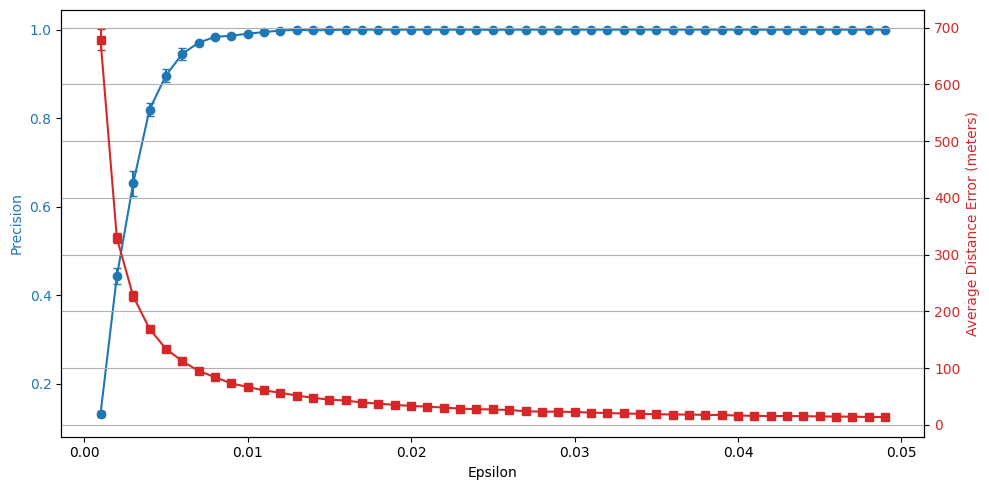

In [42]:
##plot results

import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(10, 5))

color1 = 'tab:blue'
ax1.set_xlabel("Epsilon")
ax1.set_ylabel("Precision", color=color1)
ax1.errorbar(epsilons, precision_avg, yerr=precision_std, label="Precision", fmt='-o', color=color1, capsize=3)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()

color2 = 'tab:red'
ax2.set_ylabel("Average Distance Error (meters)", color=color2)
ax2.errorbar(epsilons, error_avg, yerr=error_std, label="Error", fmt='-s', color=color2, capsize=3)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.grid(True)

plt.savefig("precision_error_combined.png", dpi=300)
plt.show()

tWe measure the privacy / utility trade-off by defining the Jaccard index as our metric. The Jaccard index measures similarity between two sets and is defined as the size of the intersection divided by the size of the union of the two sets. It is a value between 0 and 1, where 0 means no similarity (no element is in both sets) and 1 means perfect similarity (the two sets are equal). We will use it to measure the similarity between the set of POIs returned by the server for the obfuscated queries and the set of POIs returned for the original queries.


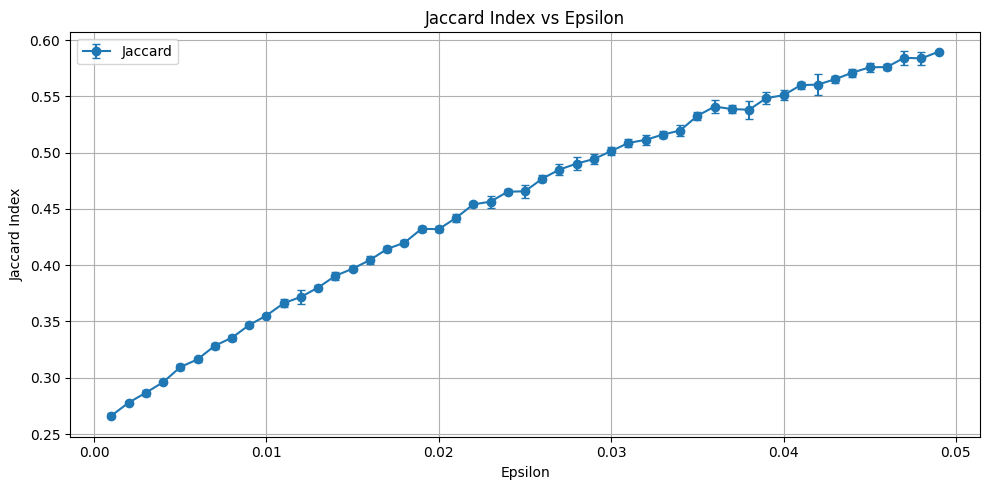

In [37]:
plt.figure(figsize=(10, 5))
plt.errorbar(epsilons, jaccard_avg, yerr=jaccard_std, label="Jaccard", fmt='-o', capsize=3)
plt.title("Jaccard Index vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Jaccard Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("jaccard.png")
plt.show()